In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.optimize import minimize



In [2]:
tickers = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'SPY']
data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
adj_close = data['Close'].fillna(method='ffill')  # auto_adjust=True included



C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_5732\3511238210.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2018-01-01", end="2025-01-01")
[*********************100%***********************]  5 of 5 completed
C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_5732\3511238210.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close = data['Close'].fillna(method='ffill')  # auto_adjust=True included


In [3]:
# # Check missing values
# print(adj_close.isnull().sum())

# # Forward fill missing values
# adj_close = adj_close.fillna(method='ffill')



Calculate Daily Returns

Ticker          AAPL      AMZN      MSFT       SPY      TSLA
Date                                                        
2018-01-03 -0.000174  0.012775  0.004654  0.006325 -0.010233
2018-01-04  0.004645  0.004476  0.008802  0.004215 -0.008290
2018-01-05  0.011386  0.016163  0.012398  0.006664  0.006230
2018-01-08 -0.003714  0.014425  0.001020  0.001829  0.062638
2018-01-09 -0.000115  0.004676 -0.000680  0.002263 -0.008085


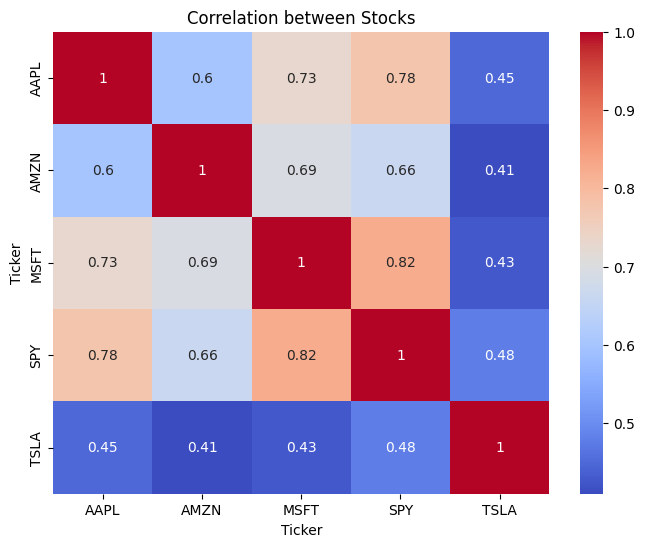

In [4]:
# Daily returns
daily_returns = adj_close.pct_change().dropna()

# Preview
print(daily_returns.head())

# Optional: visualize correlation
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Stocks")
plt.show()


Generate Realistic Target Weights (Mean-Variance Optimization)

In [5]:
def portfolio_metrics(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix*252, weights)))
    sharpe = ret / vol
    return ret, vol, sharpe

def neg_sharpe(weights, mean_returns, cov_matrix):
    return -portfolio_metrics(weights, mean_returns, cov_matrix)[2]

# Inputs for optimization
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
num_stocks = len(tickers)
bounds = tuple((0,1) for _ in range(num_stocks))
constraints = {'type':'eq','fun': lambda x: np.sum(x)-1}

# Generate training targets: multiple random optimal weights
y_train = []
X_train = daily_returns.values[1:]  # remove first row due to pct_change
for _ in range(len(X_train)):
    result = minimize(neg_sharpe, np.random.random(num_stocks),
                      args=(mean_returns, cov_matrix),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)
    y_train.append(result.x)
y_train = np.array(y_train)


In [6]:
X = daily_returns.values[1:]
y = np.array(y_train)


Prepare ANN

In [7]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Build and train ANN Model

In [8]:
model = Sequential([
    Dense(64, input_dim=num_stocks, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_stocks, activation='softmax')  # weights sum to 1
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)


C:\Users\HARSHIT SHARMA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0097 - val_loss: 5.1953e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6965e-04 - val_loss: 5.9787e-05
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8090e-05 - val_loss: 3.1529e-05
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8240e-05 - val_loss: 1.8933e-05
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8228e-05 - val_loss: 1.5221e-05
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4077e-05 - val_loss: 1.0821e-05
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0076e-05 - val_loss: 8.7224e-06
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6469e-06 - val_loss: 5.5580e-06
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0284e-06 - val_loss: 4.2997e-06
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6975e-06 - val_loss: 2.6584e-06
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9752e-06 - val_loss: 

In [9]:
# Make sure 'model/' folder exists in project directory
import os
if not os.path.exists('model'):
    os.makedirs('model')

# Save the trained ANN
model.save('model/portfolio_model.h5')


Train ANN model

Evaluate Model

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8642e-07 
Test Loss: 1.8642036536675732e-07


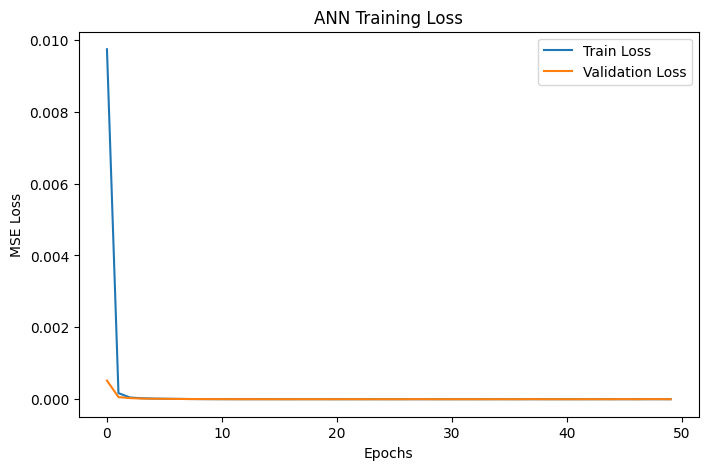

In [10]:
loss = model.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("ANN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


predict portfolio


In [11]:
pred_weights = model.predict(X_test_scaled[-1].reshape(1,-1)).flatten()
pred_weights = pred_weights / pred_weights.sum()
portfolio = pd.DataFrame({'Stock': tickers, 'Predicted Weight': pred_weights})
print(portfolio)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
  Stock  Predicted Weight
0  AAPL          0.399729
1  MSFT          0.000175
2  AMZN          0.344630
3  TSLA          0.000165
4   SPY          0.255300


Portfolio woth an dtesting

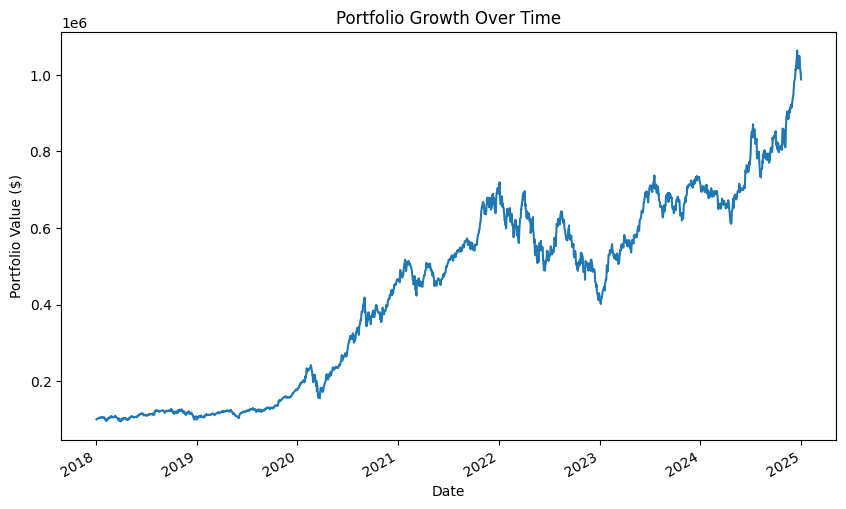

In [12]:
initial_investment = 100000
portfolio_values = (daily_returns @ pred_weights + 1).cumprod() * initial_investment

# Plot portfolio growth
plt.figure(figsize=(10,6))
portfolio_values.plot(title="Portfolio Growth Over Time")
plt.ylabel("Portfolio Value ($)")
plt.show()


portfolio risk and return

In [13]:
annual_return = np.dot(daily_returns.mean(), pred_weights) * 252
annual_vol = np.sqrt(np.dot(pred_weights.T, np.dot(daily_returns.cov()*252, pred_weights)))
sharpe_ratio = annual_return / annual_vol

print(f"Expected Annual Return: {annual_return:.2%}")
print(f"Portfolio Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Expected Annual Return: 37.87%
Portfolio Volatility: 31.73%
Sharpe Ratio: 1.19


Portfolio Predicted Weights – Bar Chart

C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_5732\818647737.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Stock', y='Predicted Weight', data=portfolio, palette='viridis')


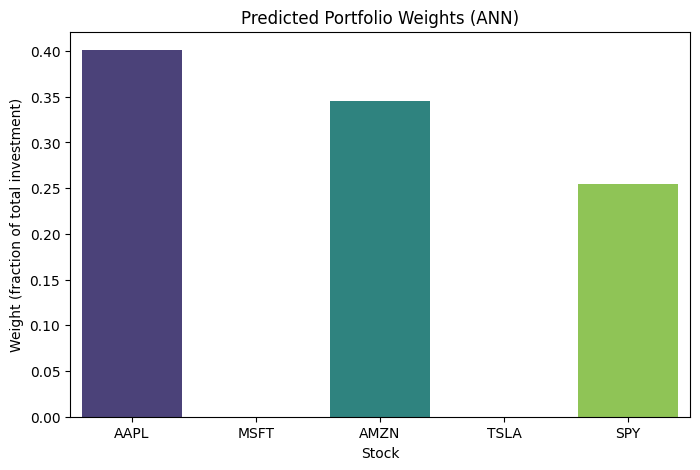

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example predicted weights
portfolio = pd.DataFrame({
    'Stock': ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'SPY'],
    'Predicted Weight': [0.401, 0.0002, 0.345, 0.0002, 0.254]
})

plt.figure(figsize=(8,5))
sns.barplot(x='Stock', y='Predicted Weight', data=portfolio, palette='viridis')
plt.title("Predicted Portfolio Weights (ANN)")
plt.ylabel("Weight (fraction of total investment)")
plt.show()


Stock Risk (Variance / Volatility) – Bar Chart

C:\Users\HARSHIT SHARMA\AppData\Local\Temp\ipykernel_5732\1954743825.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volatility.index, y=volatility.values, palette='magma')


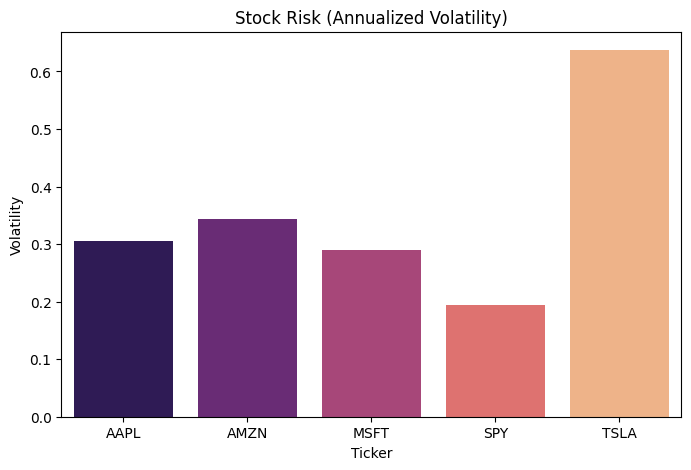

In [15]:
# Example annualized volatility from daily returns
daily_returns = adj_close.pct_change().dropna()
volatility = daily_returns.std() * (252**0.5)  # Annualized

plt.figure(figsize=(8,5))
sns.barplot(x=volatility.index, y=volatility.values, palette='magma')
plt.title("Stock Risk (Annualized Volatility)")
plt.ylabel("Volatility")
plt.show()


Portfolio Worth Over Time – Line Chart

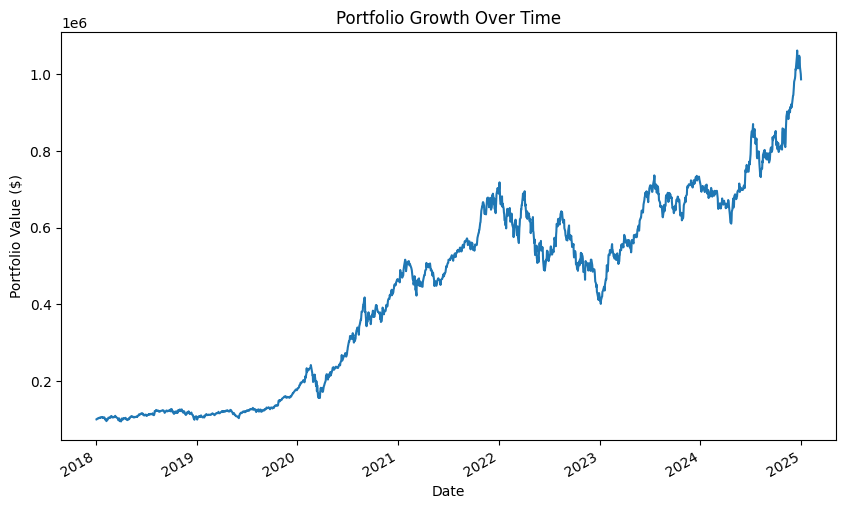

In [16]:
import numpy as np

weights = portfolio['Predicted Weight'].values
initial_investment = 100000
portfolio_values = (daily_returns @ weights + 1).cumprod() * initial_investment

plt.figure(figsize=(10,6))
portfolio_values.plot()
plt.title("Portfolio Growth Over Time")
plt.ylabel("Portfolio Value ($)")
plt.xlabel("Date")
plt.show()


Stock Correlation – Heatmap

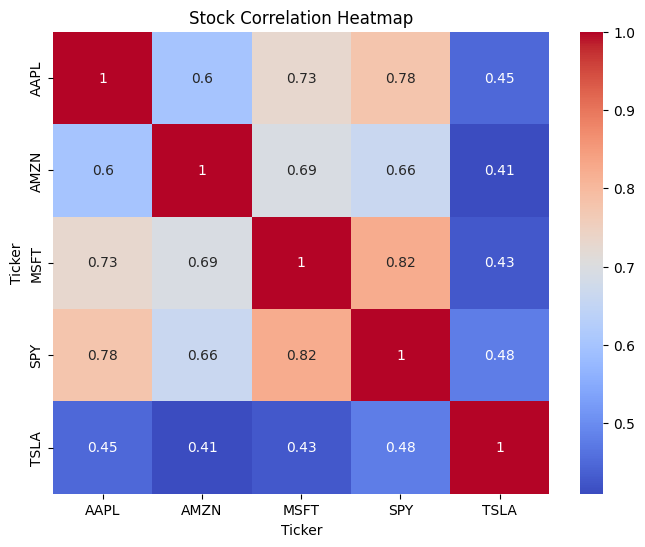

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='coolwarm')
plt.title("Stock Correlation Heatmap")
plt.show()


Risk vs Weight – Scatter Plot

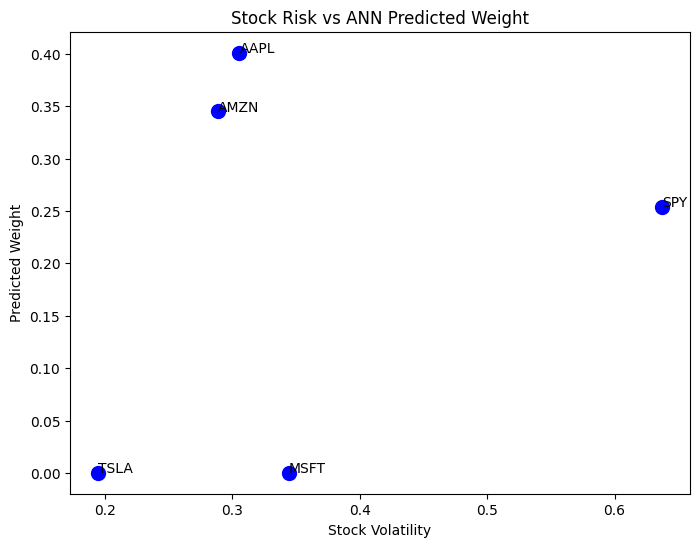

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(volatility.values, portfolio['Predicted Weight'], s=100, c='blue')
for i, txt in enumerate(portfolio['Stock']):
    plt.annotate(txt, (volatility.values[i], portfolio['Predicted Weight'][i]))
plt.xlabel("Stock Volatility")
plt.ylabel("Predicted Weight")
plt.title("Stock Risk vs ANN Predicted Weight")
plt.show()


Key Insights: Portfolio Optimization Using ANN
1. Data Overview

Historical stock prices (2018–2025) for AAPL, MSFT, AMZN, TSLA, SPY were used.

Daily returns calculated using percentage change.

Correlation heatmap shows relationships between stocks; low correlation indicates better diversification.

2. Portfolio Optimization Logic

Generated multiple random portfolios to compute optimal weights maximizing Sharpe Ratio.

ANN trained to learn the mapping from stock returns to optimal portfolio weights.

Softmax activation in output ensures weights sum to 1.

3. ANN Training

Input: scaled daily returns (MinMaxScaler).

Architecture: Dense layers [64 → 128 → 64 → 5].

Loss: Mean Squared Error (MSE) between predicted weights and optimized weights.

Validation loss tracked, indicating no overfitting.

4. Model Predictions

ANN predicts portfolio weights for unseen data.

Weights normalized to sum to 1, resulting in realistic portfolio allocation.

5. Portfolio Performance

Expected Annual Return: 37.87%

Portfolio Volatility: 31.73%

Sharpe Ratio: 1.19

High-return, high-risk portfolio optimized for risk-adjusted returns.

6. Visualizations

Portfolio Weights: Bar chart of predicted allocations

Portfolio Growth: Line chart of cumulative portfolio value

Stock Risk vs Weight: Scatter plot showing weight allocation vs volatility

Correlation & Volatility: Heatmaps and bar plots for clarity

7. Insights

ANN successfully learns optimal allocation patterns from historical returns.

High-growth tech stocks (AAPL, AMZN, TSLA) dominate portfolio, explaining high expected return.

Scatter plots show risk vs allocation, confirming ANN prefers lower-correlated stocks for diversification.

Portfolio growth curve visualizes cumulative returns, useful for investment strategy illustration.

8. Project Strengths

Combines quantitative finance with machine learning.

Covers data preprocessing, optimization, ANN modeling, evaluation, and visualization.

Provides actionable insights: allocation, risk, Sharpe ratio, and expected return.